In [0]:
pip install matplotlib==3.1.0

In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [0]:
df = pd.read_csv('real_final_dataset.csv')

In [0]:
df= df.drop('Unnamed: 0', axis =1)
df = df.drop_duplicates()
df= df.rename(columns={"lower_conv": "price_estimate_lower", 'upper_conv': "price_estimate_upper"})
df.shape

(65096, 4)

**TOKENIZING**

In [0]:
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = text.replace('x', '') #    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [0]:
df['name/decrip'] = df['name/decrip'].apply(clean_text)

In [0]:
!pip install tensorflow

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 1000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['name/decrip'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 67282 unique tokens.


**VARIABLES AND FEATURES**
> **Prices divided into 10 classes - quantile cut**

In [0]:
X = tokenizer.texts_to_sequences(df['name/decrip'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (65096, 250)


In [0]:
Y = np.log(df.converted).to_numpy()

In [0]:
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
est.fit(Y.reshape(-1,1))  
Yt = est.transform(Y.reshape(-1,1))
Yt  

array([[5.],
       [5.],
       [7.],
       ...,
       [4.],
       [5.],
       [2.]])

**TRAIN/TEST SPLIT**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Yt, test_size = 0.20, random_state = 42)


**SIMPLE CLASSIFICATION MODEL (TEXT ONLY)**

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, dropout=0.3, recurrent_dropout=0.3)))


model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['mse'])

epochs = 6
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.3)


Train on 36453 samples, validate on 15623 samples
Epoch 1/6
36453/36453 [==============================] - 932s 26ms/sample - loss: 1.8416 - mean_squared_error: 27.6262 - val_loss: 1.7247 - val_mean_squared_error: 27.9233
Epoch 2/6
36453/36453 [==============================] - 930s 26ms/sample - loss: 1.6468 - mean_squared_error: 27.6307 - val_loss: 1.6990 - val_mean_squared_error: 27.9281
Epoch 3/6
36453/36453 [==============================] - 933s 26ms/sample - loss: 1.5145 - mean_squared_error: 27.6347 - val_loss: 1.7369 - val_mean_squared_error: 27.9301
Epoch 4/6
36453/36453 [==============================] - 936s 26ms/sample - loss: 1.3920 - mean_squared_error: 27.6391 - val_loss: 1.7839 - val_mean_squared_error: 27.9322
Epoch 5/6
36453/36453 [==============================] - 931s 26ms/sample - loss: 1.2994 - mean_squared_error: 27.6431 - val_loss: 1.8420 - val_mean_squared_error: 27.9355
Epoch 6/6
36453/36453 [==============================] - 939s 26ms/sample - loss: 1.2174 -

**EVALUATE MODEL**

In [0]:
accr = model.evaluate(X_test,Y_test)
print('accuracy: {}'.format(accr))

13020/13020 [==============================] - 65s 5ms/sample - loss: 1.9196 - mean_squared_error: 28.0363
accuracy: [1.9195883778383105, 28.036274]


In [0]:
val_preds = model.predict(X_test)

In [0]:
pos_pred = val_preds.argmax(axis =1) 

In [0]:
pos_pred

array([5, 5, 6, ..., 4, 9, 4])

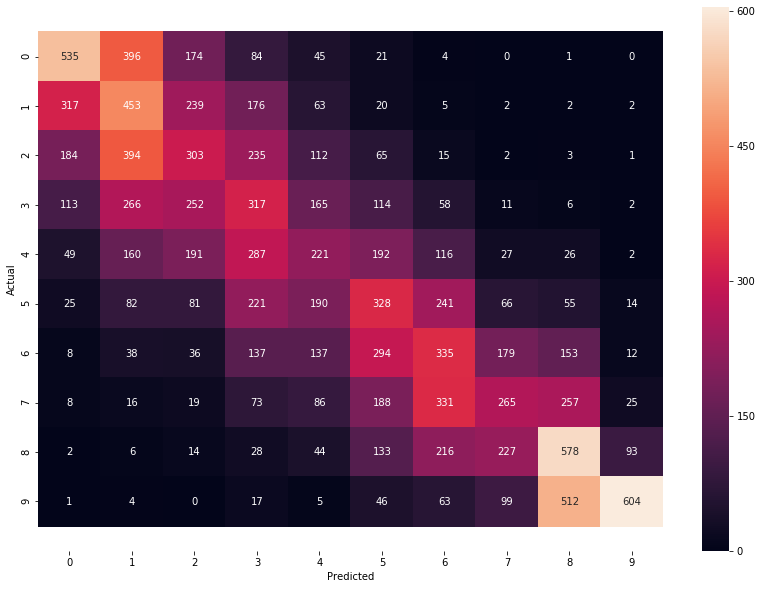

In [0]:

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(Y_test, pos_pred)
fig, ax = plt.subplots(figsize=(14,10))

sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [0]:
acc_df = pd.DataFrame({'test': Y_test.ravel(), 'pred': pos_pred.ravel()})

In [0]:
acc_df

,test,pred
0,6.0,5
1,6.0,5
2,4.0,6
3,8.0,8
4,9.0,9
...,...,...
13015,8.0,7
13016,4.0,4
13017,5.0,4
13018,9.0,9


In [0]:
acc_df['dif'] = (acc_df.test - acc_df.pred)

In [0]:
acc_df

,test,pred,dif
0,6.0,5,1.0
1,6.0,5,1.0
2,4.0,6,-2.0
3,8.0,8,0.0
4,9.0,9,0.0
...,...,...,...
13015,8.0,7,1.0
13016,4.0,4,0.0
13017,5.0,4,1.0
13018,9.0,9,0.0


In [0]:
(np.sum(acc_df.dif)) / len(acc_df)

0.3633640552995392